In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Thu Jul  9 15:11:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 20%   36C    P0    32W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mds_07July2020 import All_CNN6Layer_A as ModelA
from model.models_mds_07July2020 import All_CNN6Layer_B as ModelB
from model.models_mds_07July2020 import All_CNN6Layer_C as ModelC
from model.models_mds_07July2020 import All_CNN6Layer_D as ModelD
from model.models_mds_07July2020 import All_CNN6Layer_E as ModelE

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 200, 1e-3, 398)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Aug14_80K_train.h5 in 10.81 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 11.83 s
Constructing 160000 event dataset took 3.526 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 2.585 s
Constructing 9984 event dataset took 0.104 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


ct, child =  0    Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  1    Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  2    Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  3    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  4    Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  5    Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
ct, child =  6    Dropout(p=0.15, inplace=False)
ct, child =  7    Dropout(p=0.15, inplace=False)
ct, child =  8    Dropout(p=0.15, inplace=False)
ct, child =  9    Dropout(p=0.15, inplace=False)
ct, child =  10    Dropout(p=0.15, inplace=False)


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

path = 'run_stats.pyt'
load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/d4c36a4ce6a24fa084bf844256bee04f/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

Of the 12 parameter layers to update in the current model, 12 were loaded
Of the 12 parameter layers to update in the current model, 8 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN6Layer_C(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3a): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


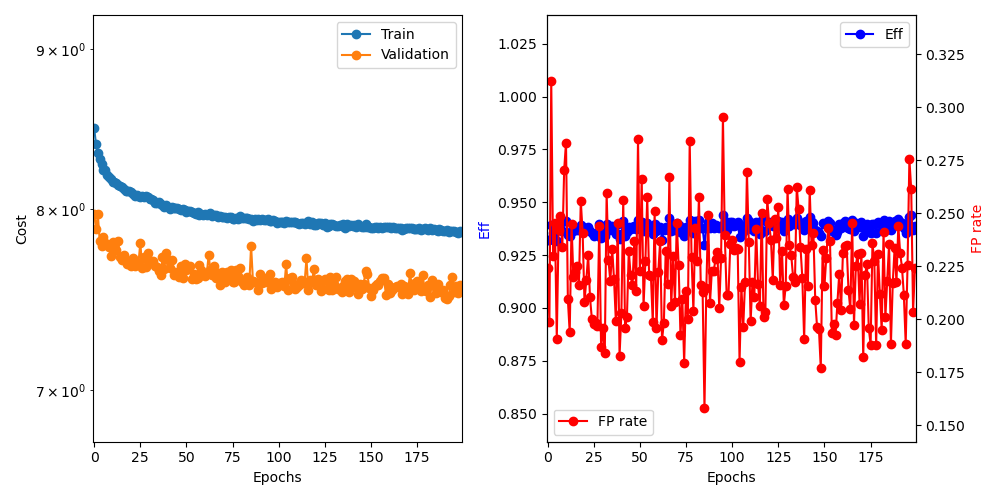

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [12]:
print('for model: ', model)   
run_name = 'ACNN 2'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
        plt.tight_layout()
        fig.savefig('plot.png')
            
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
        HL.transforms.Fold("Conv", "Conv"),
        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
        # save plot
        mlflow.log_artifact('plot.png')

for model:  All_CNN6Layer_C(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3a): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)
epoch_start 398
batch_size 128
epochs 200
lr 0.001
Number of batches: train = 1250, val = 78


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 398: train=8.48836, val=7.96988, took 36.11 s
  Validation Found 50818 of 54504, added 2241 (eff 93.24%) (0.224 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 399: train=8.38941, val=7.88272, took 35.489 s
  Validation Found 50806 of 54504, added 1986 (eff 93.22%) (0.199 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 400: train=8.33349, val=7.96665, took 35.524 s
  Validation Found 51203 of 54504, added 3119 (eff 93.94%) (0.312 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 401: train=8.29683, val=7.8112, took 34.571 s
  Validation Found 50997 of 54504, added 2293 (eff 93.57%) (0.23 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 402: train=8.26621, val=7.78649, took 34.602 s
  Validation Found 51128 of 54504, added 2451 (eff 93.81%) (0.245 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 403: train=8.2352, val=7.83344, took 34.593 s
  Validation Found 50771 of 54504, added 1905 (eff 93.15%) (0.191 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 404: train=8.23038, val=7.80264, took 34.524 s
  Validation Found 51056 of 54504, added 2419 (eff 93.67%) (0.242 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 405: train=8.20097, val=7.79335, took 35.977 s
  Validation Found 51119 of 54504, added 2483 (eff 93.79%) (0.249 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 406: train=8.18965, val=7.7791, took 35.555 s
  Validation Found 51032 of 54504, added 2338 (eff 93.63%) (0.234 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 407: train=8.17984, val=7.72625, took 34.518 s
  Validation Found 51291 of 54504, added 2701 (eff 94.11%) (0.271 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 408: train=8.16272, val=7.80535, took 34.512 s
  Validation Found 51285 of 54504, added 2830 (eff 94.09%) (0.283 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 409: train=8.161, val=7.7992, took 34.475 s
  Validation Found 50929 of 54504, added 2091 (eff 93.44%) (0.209 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 410: train=8.15554, val=7.76277, took 34.539 s
  Validation Found 50907 of 54504, added 1935 (eff 93.40%) (0.194 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 411: train=8.14029, val=7.81538, took 36.396 s
  Validation Found 51073 of 54504, added 2444 (eff 93.71%) (0.245 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 412: train=8.13465, val=7.7185, took 35.575 s
  Validation Found 51041 of 54504, added 2195 (eff 93.65%) (0.22 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 413: train=8.12881, val=7.70239, took 35.574 s
  Validation Found 51081 of 54504, added 2218 (eff 93.72%) (0.222 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 414: train=8.11693, val=7.72968, took 35.463 s
  Validation Found 51063 of 54504, added 2247 (eff 93.69%) (0.225 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 415: train=8.10804, val=7.70195, took 35.489 s
  Validation Found 51064 of 54504, added 2160 (eff 93.69%) (0.216 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 416: train=8.10331, val=7.68404, took 35.698 s
  Validation Found 51203 of 54504, added 2555 (eff 93.94%) (0.256 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 417: train=8.10659, val=7.68234, took 35.612 s
  Validation Found 51152 of 54504, added 2406 (eff 93.85%) (0.241 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 418: train=8.1002, val=7.67248, took 35.51 s
  Validation Found 51047 of 54504, added 2080 (eff 93.66%) (0.208 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 419: train=8.08848, val=7.71493, took 35.525 s
  Validation Found 51087 of 54504, added 2182 (eff 93.73%) (0.219 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 420: train=8.07691, val=7.67011, took 35.471 s
  Validation Found 51137 of 54504, added 2298 (eff 93.82%) (0.23 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 421: train=8.08295, val=7.68273, took 34.563 s
  Validation Found 51035 of 54504, added 2100 (eff 93.64%) (0.21 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 422: train=8.07805, val=7.68732, took 34.568 s
  Validation Found 50985 of 54504, added 1999 (eff 93.54%) (0.2 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 423: train=8.07032, val=7.80342, took 34.382 s
  Validation Found 50898 of 54504, added 1973 (eff 93.38%) (0.198 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 424: train=8.07599, val=7.65773, took 34.537 s
  Validation Found 50996 of 54504, added 1979 (eff 93.56%) (0.198 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 425: train=8.07021, val=7.72342, took 35.586 s
  Validation Found 50933 of 54504, added 1966 (eff 93.45%) (0.197 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 426: train=8.07339, val=7.66299, took 35.594 s
  Validation Found 51231 of 54504, added 2435 (eff 93.99%) (0.244 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 427: train=8.06761, val=7.74103, took 35.08 s
  Validation Found 50857 of 54504, added 1865 (eff 93.31%) (0.187 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 428: train=8.0572, val=7.69507, took 35.731 s
  Validation Found 50985 of 54504, added 1954 (eff 93.54%) (0.196 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 429: train=8.05889, val=7.69765, took 35.607 s
  Validation Found 50918 of 54504, added 1839 (eff 93.42%) (0.184 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 430: train=8.0499, val=7.69954, took 35.482 s
  Validation Found 51208 of 54504, added 2590 (eff 93.95%) (0.259 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 431: train=8.03731, val=7.66835, took 35.438 s
  Validation Found 51129 of 54504, added 2275 (eff 93.81%) (0.228 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 432: train=8.0367, val=7.66253, took 35.173 s
  Validation Found 51077 of 54504, added 2176 (eff 93.71%) (0.218 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 433: train=8.04167, val=7.6429, took 34.599 s
  Validation Found 51158 of 54504, added 2329 (eff 93.86%) (0.233 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 434: train=8.02664, val=7.61681, took 34.716 s
  Validation Found 51147 of 54504, added 2188 (eff 93.84%) (0.219 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 435: train=8.02407, val=7.72124, took 34.683 s
  Validation Found 50957 of 54504, added 1988 (eff 93.49%) (0.199 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 436: train=8.0095, val=7.65565, took 35.385 s
  Validation Found 51214 of 54504, added 2453 (eff 93.96%) (0.246 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 437: train=8.02441, val=7.7446, took 34.468 s
  Validation Found 50825 of 54504, added 1825 (eff 93.25%) (0.183 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 438: train=8.01074, val=7.70563, took 36.39 s
  Validation Found 50957 of 54504, added 2026 (eff 93.49%) (0.203 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 439: train=7.9987, val=7.65881, took 35.635 s
  Validation Found 51298 of 54504, added 2560 (eff 94.12%) (0.256 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 440: train=8.01038, val=7.7038, took 35.468 s
  Validation Found 50903 of 54504, added 1955 (eff 93.39%) (0.196 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 441: train=8.00539, val=7.62024, took 35.466 s
  Validation Found 51020 of 54504, added 2007 (eff 93.61%) (0.201 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 442: train=8.00709, val=7.63465, took 35.628 s
  Validation Found 51140 of 54504, added 2321 (eff 93.83%) (0.232 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 443: train=8.00392, val=7.62879, took 34.855 s
  Validation Found 51080 of 54504, added 2204 (eff 93.72%) (0.221 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 444: train=8.00039, val=7.60606, took 34.703 s
  Validation Found 51139 of 54504, added 2159 (eff 93.83%) (0.216 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 445: train=7.99054, val=7.66771, took 34.489 s
  Validation Found 51158 of 54504, added 2366 (eff 93.86%) (0.237 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 446: train=8.00055, val=7.6042, took 34.489 s
  Validation Found 51103 of 54504, added 2131 (eff 93.76%) (0.213 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 447: train=7.99198, val=7.68077, took 34.489 s
  Validation Found 51334 of 54504, added 2846 (eff 94.18%) (0.285 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 448: train=7.98255, val=7.64721, took 34.465 s
  Validation Found 51081 of 54504, added 2223 (eff 93.72%) (0.223 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 449: train=7.98471, val=7.65669, took 35.092 s
  Validation Found 51260 of 54504, added 2660 (eff 94.05%) (0.266 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 450: train=7.98847, val=7.67065, took 34.545 s
  Validation Found 51032 of 54504, added 2059 (eff 93.63%) (0.206 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 451: train=7.98113, val=7.59766, took 34.604 s
  Validation Found 51191 of 54504, added 2271 (eff 93.92%) (0.227 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 452: train=7.97597, val=7.6254, took 34.589 s
  Validation Found 51246 of 54504, added 2572 (eff 94.02%) (0.258 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 453: train=7.972, val=7.59647, took 34.556 s
  Validation Found 51153 of 54504, added 2207 (eff 93.85%) (0.221 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 454: train=7.9835, val=7.60453, took 34.795 s
  Validation Found 51133 of 54504, added 2199 (eff 93.82%) (0.22 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 455: train=7.96621, val=7.67488, took 34.369 s
  Validation Found 50973 of 54504, added 1982 (eff 93.52%) (0.198 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 456: train=7.96922, val=7.64846, took 34.632 s
  Validation Found 51210 of 54504, added 2506 (eff 93.96%) (0.251 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 457: train=7.96397, val=7.63178, took 34.669 s
  Validation Found 51027 of 54504, added 1954 (eff 93.62%) (0.196 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 458: train=7.97164, val=7.61386, took 34.6 s
  Validation Found 51147 of 54504, added 2222 (eff 93.84%) (0.223 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 459: train=7.96238, val=7.6278, took 34.519 s
  Validation Found 51152 of 54504, added 2367 (eff 93.85%) (0.237 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 460: train=7.97212, val=7.72995, took 34.359 s
  Validation Found 50815 of 54504, added 1899 (eff 93.23%) (0.19 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 461: train=7.97356, val=7.64478, took 34.564 s
  Validation Found 51056 of 54504, added 1981 (eff 93.67%) (0.198 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 462: train=7.95901, val=7.62061, took 34.573 s
  Validation Found 51151 of 54504, added 2320 (eff 93.85%) (0.232 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 463: train=7.9657, val=7.67162, took 34.578 s
  Validation Found 51060 of 54504, added 2163 (eff 93.68%) (0.217 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 464: train=7.96079, val=7.60224, took 34.324 s
  Validation Found 51362 of 54504, added 2666 (eff 94.24%) (0.267 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 465: train=7.9506, val=7.63278, took 34.507 s
  Validation Found 51041 of 54504, added 2059 (eff 93.65%) (0.206 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 466: train=7.95698, val=7.5624, took 35.326 s
  Validation Found 51219 of 54504, added 2294 (eff 93.97%) (0.23 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 467: train=7.94993, val=7.63352, took 34.472 s
  Validation Found 51068 of 54504, added 2077 (eff 93.70%) (0.208 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 468: train=7.94962, val=7.59707, took 34.619 s
  Validation Found 51258 of 54504, added 2452 (eff 94.04%) (0.246 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 469: train=7.94913, val=7.57935, took 35.665 s
  Validation Found 51201 of 54504, added 2253 (eff 93.94%) (0.226 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 470: train=7.94697, val=7.63666, took 35.478 s
  Validation Found 51013 of 54504, added 1922 (eff 93.59%) (0.192 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 471: train=7.94931, val=7.61214, took 35.608 s
  Validation Found 51088 of 54504, added 2092 (eff 93.73%) (0.21 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 472: train=7.95069, val=7.64528, took 35.46 s
  Validation Found 50900 of 54504, added 1793 (eff 93.39%) (0.18 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 473: train=7.94238, val=7.5777, took 35.535 s
  Validation Found 51134 of 54504, added 2132 (eff 93.82%) (0.214 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 474: train=7.94269, val=7.58173, took 35.558 s
  Validation Found 51092 of 54504, added 1998 (eff 93.74%) (0.2 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 475: train=7.94568, val=7.64908, took 34.783 s
  Validation Found 51323 of 54504, added 2837 (eff 94.16%) (0.284 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 476: train=7.94176, val=7.61346, took 34.816 s
  Validation Found 51186 of 54504, added 2290 (eff 93.91%) (0.229 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 477: train=7.95798, val=7.65822, took 35.9 s
  Validation Found 50982 of 54504, added 2038 (eff 93.54%) (0.204 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 478: train=7.94686, val=7.57949, took 35.26 s
  Validation Found 51290 of 54504, added 2425 (eff 94.10%) (0.243 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 479: train=7.94561, val=7.56062, took 35.103 s
  Validation Found 51238 of 54504, added 2272 (eff 94.01%) (0.228 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 480: train=7.94791, val=7.57311, took 35.057 s
  Validation Found 51314 of 54504, added 2574 (eff 94.15%) (0.258 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 481: train=7.94321, val=7.60577, took 35.037 s
  Validation Found 51114 of 54504, added 2161 (eff 93.78%) (0.216 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 482: train=7.93903, val=7.56209, took 35.016 s
  Validation Found 51115 of 54504, added 2128 (eff 93.78%) (0.213 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 483: train=7.94248, val=7.78527, took 35.038 s
  Validation Found 50672 of 54504, added 1578 (eff 92.97%) (0.158 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 484: train=7.93133, val=7.58542, took 35.113 s
  Validation Found 51119 of 54504, added 2143 (eff 93.79%) (0.215 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 485: train=7.94291, val=7.58105, took 35.245 s
  Validation Found 51260 of 54504, added 2488 (eff 94.05%) (0.249 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 486: train=7.93234, val=7.57523, took 34.231 s
  Validation Found 51121 of 54504, added 2075 (eff 93.79%) (0.208 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 487: train=7.9426, val=7.53479, took 34.378 s
  Validation Found 51241 of 54504, added 2226 (eff 94.01%) (0.223 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 488: train=7.93235, val=7.6225, took 34.288 s
  Validation Found 51106 of 54504, added 2225 (eff 93.77%) (0.223 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 489: train=7.93769, val=7.57705, took 34.614 s
  Validation Found 51193 of 54504, added 2280 (eff 93.93%) (0.228 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 490: train=7.93429, val=7.60083, took 34.367 s
  Validation Found 51154 of 54504, added 2312 (eff 93.85%) (0.232 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 491: train=7.93196, val=7.58192, took 34.534 s
  Validation Found 51117 of 54504, added 2049 (eff 93.79%) (0.205 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 492: train=7.94229, val=7.59138, took 34.101 s
  Validation Found 51166 of 54504, added 2287 (eff 93.88%) (0.229 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 493: train=7.93026, val=7.62589, took 34.289 s
  Validation Found 51463 of 54504, added 2951 (eff 94.42%) (0.296 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 494: train=7.92584, val=7.54206, took 34.101 s
  Validation Found 51284 of 54504, added 2395 (eff 94.09%) (0.24 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 495: train=7.93342, val=7.57585, took 34.161 s
  Validation Found 51066 of 54504, added 2112 (eff 93.69%) (0.212 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 496: train=7.93106, val=7.58155, took 34.305 s
  Validation Found 51132 of 54504, added 2113 (eff 93.81%) (0.212 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 497: train=7.9197, val=7.54988, took 34.139 s
  Validation Found 51262 of 54504, added 2353 (eff 94.05%) (0.236 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 498: train=7.92212, val=7.57662, took 34.084 s
  Validation Found 51273 of 54504, added 2373 (eff 94.07%) (0.238 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 499: train=7.92152, val=7.57694, took 34.146 s
  Validation Found 51178 of 54504, added 2324 (eff 93.90%) (0.233 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 500: train=7.92256, val=7.58211, took 34.072 s
  Validation Found 51182 of 54504, added 2334 (eff 93.91%) (0.234 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 501: train=7.91758, val=7.55879, took 34.134 s
  Validation Found 51267 of 54504, added 2326 (eff 94.06%) (0.233 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 502: train=7.92608, val=7.68103, took 34.267 s
  Validation Found 50884 of 54504, added 1796 (eff 93.36%) (0.18 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 503: train=7.92079, val=7.53666, took 34.086 s
  Validation Found 51184 of 54504, added 2150 (eff 93.91%) (0.215 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 504: train=7.92321, val=7.6041, took 34.0 s
  Validation Found 51007 of 54504, added 1960 (eff 93.58%) (0.196 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 505: train=7.92008, val=7.60875, took 34.166 s
  Validation Found 51092 of 54504, added 2175 (eff 93.74%) (0.218 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 506: train=7.9221, val=7.57125, took 34.16 s
  Validation Found 51386 of 54504, added 2693 (eff 94.28%) (0.27 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 507: train=7.92182, val=7.54134, took 34.202 s
  Validation Found 51294 of 54504, added 2363 (eff 94.11%) (0.237 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 508: train=7.91941, val=7.5521, took 35.168 s
  Validation Found 51097 of 54504, added 1987 (eff 93.75%) (0.199 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 509: train=7.91167, val=7.56218, took 35.25 s
  Validation Found 51137 of 54504, added 2174 (eff 93.82%) (0.218 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 510: train=7.91614, val=7.59309, took 35.24 s
  Validation Found 51045 of 54504, added 2100 (eff 93.65%) (0.21 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 511: train=7.91771, val=7.57441, took 34.294 s
  Validation Found 51274 of 54504, added 2423 (eff 94.07%) (0.243 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 512: train=7.91361, val=7.5796, took 34.335 s
  Validation Found 51144 of 54504, added 2164 (eff 93.84%) (0.217 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 513: train=7.91922, val=7.71292, took 34.375 s
  Validation Found 50951 of 54504, added 2058 (eff 93.48%) (0.206 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 514: train=7.92607, val=7.53467, took 34.31 s
  Validation Found 51330 of 54504, added 2500 (eff 94.18%) (0.25 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 515: train=7.91261, val=7.5914, took 34.196 s
  Validation Found 51031 of 54504, added 2007 (eff 93.63%) (0.201 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 516: train=7.92124, val=7.58276, took 34.917 s
  Validation Found 51051 of 54504, added 2033 (eff 93.66%) (0.204 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 517: train=7.90736, val=7.65158, took 34.258 s
  Validation Found 51275 of 54504, added 2565 (eff 94.08%) (0.257 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 518: train=7.9076, val=7.56094, took 34.386 s
  Validation Found 51264 of 54504, added 2449 (eff 94.06%) (0.245 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 519: train=7.91423, val=7.59779, took 33.857 s
  Validation Found 51221 of 54504, added 2373 (eff 93.98%) (0.238 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 520: train=7.91646, val=7.58814, took 33.857 s
  Validation Found 51166 of 54504, added 2183 (eff 93.88%) (0.219 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 521: train=7.91462, val=7.52996, took 34.403 s
  Validation Found 51334 of 54504, added 2469 (eff 94.18%) (0.247 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 522: train=7.90634, val=7.54258, took 34.344 s
  Validation Found 51254 of 54504, added 2378 (eff 94.04%) (0.238 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 523: train=7.91828, val=7.59652, took 34.299 s
  Validation Found 51285 of 54504, added 2524 (eff 94.09%) (0.253 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 524: train=7.89535, val=7.58342, took 34.49 s
  Validation Found 51162 of 54504, added 2157 (eff 93.87%) (0.216 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 525: train=7.8977, val=7.53346, took 35.201 s
  Validation Found 51259 of 54504, added 2319 (eff 94.05%) (0.232 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 526: train=7.90823, val=7.60673, took 34.474 s
  Validation Found 51030 of 54504, added 2065 (eff 93.63%) (0.207 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 527: train=7.91056, val=7.53482, took 34.735 s
  Validation Found 51175 of 54504, added 2153 (eff 93.89%) (0.216 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 528: train=7.90377, val=7.57024, took 34.444 s
  Validation Found 51341 of 54504, added 2609 (eff 94.20%) (0.261 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 529: train=7.89949, val=7.60717, took 34.078 s
  Validation Found 51172 of 54504, added 2347 (eff 93.89%) (0.235 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 530: train=7.90156, val=7.53856, took 34.105 s
  Validation Found 51279 of 54504, added 2298 (eff 94.08%) (0.23 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 531: train=7.90476, val=7.54473, took 34.038 s
  Validation Found 51212 of 54504, added 2197 (eff 93.96%) (0.22 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 532: train=7.90154, val=7.52284, took 34.148 s
  Validation Found 51213 of 54504, added 2171 (eff 93.96%) (0.217 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 533: train=7.90927, val=7.55536, took 34.1 s
  Validation Found 51369 of 54504, added 2621 (eff 94.25%) (0.262 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 534: train=7.89, val=7.5856, took 34.149 s
  Validation Found 51274 of 54504, added 2515 (eff 94.07%) (0.252 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 535: train=7.909, val=7.59581, took 34.207 s
  Validation Found 51183 of 54504, added 2339 (eff 93.91%) (0.234 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 536: train=7.90221, val=7.52389, took 34.323 s
  Validation Found 51236 of 54504, added 2192 (eff 94.00%) (0.22 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 537: train=7.90459, val=7.59854, took 34.339 s
  Validation Found 51066 of 54504, added 1903 (eff 93.69%) (0.191 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 538: train=7.89996, val=7.55309, took 34.337 s
  Validation Found 51298 of 54504, added 2328 (eff 94.12%) (0.233 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 539: train=7.90367, val=7.58644, took 34.123 s
  Validation Found 51121 of 54504, added 2154 (eff 93.79%) (0.216 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 540: train=7.89489, val=7.5708, took 34.138 s
  Validation Found 51396 of 54504, added 2608 (eff 94.30%) (0.261 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 541: train=7.91098, val=7.51586, took 34.193 s
  Validation Found 51276 of 54504, added 2345 (eff 94.08%) (0.235 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 542: train=7.90107, val=7.5693, took 34.137 s
  Validation Found 51244 of 54504, added 2406 (eff 94.02%) (0.241 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 543: train=7.89304, val=7.54349, took 34.163 s
  Validation Found 51074 of 54504, added 2089 (eff 93.71%) (0.209 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 544: train=7.89081, val=7.56891, took 34.1 s
  Validation Found 51047 of 54504, added 1959 (eff 93.66%) (0.196 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 545: train=7.90822, val=7.64094, took 34.198 s
  Validation Found 50993 of 54504, added 1951 (eff 93.56%) (0.195 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 546: train=7.89505, val=7.62357, took 34.136 s
  Validation Found 50914 of 54504, added 1767 (eff 93.41%) (0.177 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 547: train=7.89133, val=7.54733, took 35.118 s
  Validation Found 51242 of 54504, added 2324 (eff 94.02%) (0.233 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 548: train=7.89023, val=7.50236, took 34.281 s
  Validation Found 51210 of 54504, added 2154 (eff 93.96%) (0.216 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 549: train=7.8898, val=7.53508, took 34.256 s
  Validation Found 51218 of 54504, added 2288 (eff 93.97%) (0.229 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 550: train=7.89587, val=7.5603, took 34.318 s
  Validation Found 51297 of 54504, added 2427 (eff 94.12%) (0.243 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 551: train=7.89119, val=7.57111, took 34.393 s
  Validation Found 51244 of 54504, added 2364 (eff 94.02%) (0.237 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 552: train=7.89009, val=7.56543, took 34.131 s
  Validation Found 51041 of 54504, added 1934 (eff 93.65%) (0.194 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 553: train=7.89329, val=7.58474, took 34.095 s
  Validation Found 51067 of 54504, added 1973 (eff 93.69%) (0.198 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 554: train=7.8905, val=7.60475, took 34.959 s
  Validation Found 50937 of 54504, added 1922 (eff 93.46%) (0.192 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 555: train=7.89336, val=7.60172, took 34.13 s
  Validation Found 51008 of 54504, added 2075 (eff 93.59%) (0.208 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 556: train=7.89132, val=7.51032, took 34.138 s
  Validation Found 51213 of 54504, added 2211 (eff 93.96%) (0.221 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 557: train=7.89427, val=7.57072, took 34.367 s
  Validation Found 51108 of 54504, added 2042 (eff 93.77%) (0.205 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 558: train=7.8962, val=7.51864, took 34.407 s
  Validation Found 51249 of 54504, added 2310 (eff 94.03%) (0.231 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 559: train=7.88788, val=7.53164, took 34.365 s
  Validation Found 51295 of 54504, added 2343 (eff 94.11%) (0.235 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 560: train=7.8907, val=7.54295, took 34.388 s
  Validation Found 51251 of 54504, added 2347 (eff 94.03%) (0.235 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 561: train=7.88662, val=7.55044, took 34.31 s
  Validation Found 51117 of 54504, added 2136 (eff 93.79%) (0.214 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 562: train=7.88785, val=7.5593, took 35.226 s
  Validation Found 51100 of 54504, added 2044 (eff 93.75%) (0.205 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 563: train=7.88498, val=7.55038, took 35.139 s
  Validation Found 51334 of 54504, added 2451 (eff 94.18%) (0.245 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 564: train=7.88745, val=7.56745, took 35.028 s
  Validation Found 51049 of 54504, added 1972 (eff 93.66%) (0.197 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 565: train=7.87829, val=7.51358, took 34.4 s
  Validation Found 51234 of 54504, added 2249 (eff 94.00%) (0.225 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 566: train=7.88211, val=7.5599, took 34.182 s
  Validation Found 51189 of 54504, added 2307 (eff 93.92%) (0.231 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 567: train=7.88648, val=7.55492, took 34.145 s
  Validation Found 51144 of 54504, added 2071 (eff 93.84%) (0.207 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 568: train=7.88764, val=7.51348, took 34.019 s
  Validation Found 51267 of 54504, added 2311 (eff 94.06%) (0.231 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 569: train=7.88575, val=7.62918, took 34.041 s
  Validation Found 50907 of 54504, added 1819 (eff 93.40%) (0.182 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 570: train=7.88697, val=7.56785, took 34.105 s
  Validation Found 51148 of 54504, added 2207 (eff 93.84%) (0.221 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 571: train=7.88382, val=7.53805, took 34.102 s
  Validation Found 51214 of 54504, added 2256 (eff 93.96%) (0.226 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 572: train=7.88051, val=7.5755, took 34.14 s
  Validation Found 51038 of 54504, added 1954 (eff 93.64%) (0.196 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 573: train=7.88393, val=7.58686, took 34.702 s
  Validation Found 50978 of 54504, added 1878 (eff 93.53%) (0.188 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 574: train=7.88716, val=7.56378, took 34.289 s
  Validation Found 51219 of 54504, added 2355 (eff 93.97%) (0.236 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 575: train=7.87894, val=7.52928, took 34.253 s
  Validation Found 51215 of 54504, added 2272 (eff 93.97%) (0.228 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 576: train=7.87954, val=7.61824, took 34.545 s
  Validation Found 50994 of 54504, added 1876 (eff 93.56%) (0.188 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 577: train=7.88595, val=7.53427, took 34.19 s
  Validation Found 51271 of 54504, added 2303 (eff 94.07%) (0.231 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 578: train=7.88026, val=7.53189, took 35.145 s
  Validation Found 51207 of 54504, added 2118 (eff 93.95%) (0.212 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 579: train=7.87566, val=7.56549, took 35.118 s
  Validation Found 51057 of 54504, added 1946 (eff 93.68%) (0.195 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 580: train=7.88757, val=7.49783, took 34.212 s
  Validation Found 51322 of 54504, added 2408 (eff 94.16%) (0.241 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 581: train=7.87461, val=7.59002, took 35.185 s
  Validation Found 51052 of 54504, added 2008 (eff 93.67%) (0.201 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 582: train=7.87929, val=7.55812, took 35.113 s
  Validation Found 51186 of 54504, added 2177 (eff 93.91%) (0.218 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 583: train=7.87897, val=7.5196, took 34.526 s
  Validation Found 51306 of 54504, added 2352 (eff 94.13%) (0.236 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 584: train=7.873, val=7.5677, took 34.378 s
  Validation Found 51052 of 54504, added 1882 (eff 93.67%) (0.188 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 585: train=7.88251, val=7.54074, took 34.401 s
  Validation Found 51191 of 54504, added 2169 (eff 93.92%) (0.217 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 586: train=7.87571, val=7.52224, took 34.389 s
  Validation Found 51298 of 54504, added 2334 (eff 94.12%) (0.234 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 587: train=7.87082, val=7.53643, took 34.382 s
  Validation Found 51224 of 54504, added 2172 (eff 93.98%) (0.218 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 588: train=7.87254, val=7.48933, took 34.451 s
  Validation Found 51346 of 54504, added 2438 (eff 94.21%) (0.244 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 589: train=7.87562, val=7.48705, took 34.361 s
  Validation Found 51267 of 54504, added 2310 (eff 94.06%) (0.231 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 590: train=7.86475, val=7.50002, took 34.349 s
  Validation Found 51257 of 54504, added 2240 (eff 94.04%) (0.224 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 591: train=7.86751, val=7.56245, took 34.349 s
  Validation Found 51112 of 54504, added 2112 (eff 93.78%) (0.212 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 592: train=7.87141, val=7.60909, took 34.268 s
  Validation Found 50984 of 54504, added 1883 (eff 93.54%) (0.189 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 593: train=7.86988, val=7.5268, took 34.281 s
  Validation Found 51214 of 54504, added 2252 (eff 93.96%) (0.226 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 594: train=7.86611, val=7.55996, took 34.176 s
  Validation Found 51404 of 54504, added 2751 (eff 94.31%) (0.276 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 595: train=7.85792, val=7.51727, took 34.245 s
  Validation Found 51458 of 54504, added 2609 (eff 94.41%) (0.261 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 596: train=7.86815, val=7.5655, took 34.159 s
  Validation Found 51070 of 54504, added 2032 (eff 93.70%) (0.204 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 597: train=7.86567, val=7.55538, took 33.866 s
  Validation Found 51179 of 54504, added 2238 (eff 93.90%) (0.224 FP/event)



In [13]:
##quit()